In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tqdm

# Toy Example

We want to verify that the cdf loss helps in scenarios with limited data and label noise

In [2]:
class SimpleNoiseRegData(Dataset):
    def __init__(self, N, noise_scale = 0.2):
        super().__init__()
        if noise_scale < 0:
            # We use a data dependend noise!
            d_dim = 6
            self.weight = torch.Tensor([[-1,-0.1,0.1,0.4,1.3, 0]])
        else:
            d_dim = 5
            self.weight = torch.Tensor([[-1,-0.1,0.1,0.4,1.3]])
        
        # We first construct a very simple nonlinear regression problem, mapping from 5 dimensions to 1
        self.N = N
        self.data = torch.randn((N,d_dim))
        self.clean_labels = torch.einsum("ij, Bj -> Bi", self.weight, self.data)**2
        
        if noise_scale < 0:
            data_dependend_noise = torch.nn.functional.softplus(self.data[:,-1:]*5)
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), data_dependend_noise)
        else:
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), noise_scale)
        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        matching_idx = np.random.randint(self.N)
        return self.data[idx], self.labels[idx], self.data[matching_idx], self.labels[matching_idx] 
    

class SimpleModel(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        self.non_linearity = torch.nn.SELU()
    def forward(self, x):
        return self.out_layer(self.non_linearity(self.in_layer(x)))
    

class MatchingModel(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_out,bias=False)
    def forward(self, x):
        #return self.in_layer(x) **2
        y = self.in_layer(x)
        return torch.stack((y[:,0] **2,y[:,1]),dim=1)
    
def relative_loss(x1, x2, label, rel_temperature=0.2):
    diff_1 = x1 - x2
    diff_2 = x2 - x1 
            
    log_prob_1_ge_2 = torch.special.log_ndtr(diff_1.flatten() / 2 ** 0.5 / rel_temperature)
    log_prob_2_ge_1 = torch.special.log_ndtr(diff_2.flatten() / 2 ** 0.5 / rel_temperature)
    combined =  torch.stack((log_prob_1_ge_2, log_prob_2_ge_1), dim=-1)
    return torch.nn.functional.nll_loss(combined, label, reduction="sum")
    
def mse_loss(x1, label):
    return torch.nn.functional.mse_loss(x1, label)

def nll_loss(output, label, scale):
    return torch.sum((torch.log(torch.clamp(scale,1e-6)) + (output - label)**2 / (torch.clamp(2*scale**2,1e-6))))
    #return torch.sum(0.5 * (torch.log(2*torch.clamp(var,1e-6)**2) + (output - label)**2 / (2*torch.clamp(var,1e-6)**2)))

In [3]:
epochs = 5000
lr = 0.001
n_samples = 1000
batch_size = 500
noise_scale = -1
def init_model():
    model = SimpleModel(6,2,32)
    #model = MatchingModel(6,2)
    if torch.cuda.is_available():
            model = model.to("cuda")
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Define a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=100, factor=0.5, verbose=False)
    return model, optimizer, scheduler
dataset = SimpleNoiseRegData(n_samples, noise_scale=noise_scale)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True) 

In [4]:
val_dataset = SimpleNoiseRegData(1000, noise_scale=noise_scale)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
val_losses = {}

In [10]:
model_names = ["nll"]#"double_mse","relative","relative+mse","relative+nll","relative_detach","relative_detach+mse", "mse", "nll"]
#model_names = ["relative"]#["relative","relative+mse","relative+nll","relative_detach","relative_detach+mse"]
#epochs = 1000
lr = 0.00025
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for model_name in model_names:
    model, optimizer, scheduler = init_model()
    with tqdm.tqdm(range(epochs), unit="epoch") as tepoch:
        #model_name = "relative"
        val_losses[f"{model_name}_pearson"]=[]
        val_losses[f"{model_name}_mse"]=[]
        for epoch in tepoch:
            total_loss = 0
            for (x, y, x2, y2) in train_loader:
                if torch.cuda.is_available():
                    x = x.to("cuda")
                    y = y.to("cuda")    
                    x2 = x2.to("cuda")
                    y2 = y2.to("cuda")  
                optimizer.zero_grad()
            
                out = model(x)
                out2 = model(x2)
            
                #uncertainty = (torch.nn.functional.softplus(out[:,1]) + torch.nn.functional.softplus(out2[:,1]))/2
                if "relative" in model_name:
                    if "detach" in model_name:
                        uncertainty = (torch.nn.functional.softplus(out[:,1:]) + torch.nn.functional.softplus(out2[:,1:].detach()))/2
                    else:
                        uncertainty = (torch.nn.functional.softplus(out[:,1:]) + torch.nn.functional.softplus(out2[:,1:]))/2
                else:
                    uncertainty = torch.nn.functional.softplus(out[:,1:])
                # get loss for the predicted output
                if model_name =="relative":
                    loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0])
                elif model_name =="relative+mse":
                    loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0]) + 10 * mse_loss(out[:,:1], y)
                if model_name =="relative_detach":
                    loss = relative_loss(out[:,0], out2[:,0].detach(), (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0])
                elif model_name =="relative_detach+mse":
                    loss = relative_loss(out[:,0], out2[:,0].detach(), (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0]) + 10 * mse_loss(out[:,:1], y)
                elif model_name == "relative+nll":
                    loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0]) + 10* nll_loss(out[:,:1], y, torch.nn.functional.softplus(out[:,1:]) )
                elif model_name =="mse":
                    loss = 10*mse_loss(out[:,:1], y)
                elif model_name =="doublemse":
                    loss = 10*mse_loss(out[:,:1], y) + 10*mse_loss(out2[:,:1], y2) 
                
                elif model_name =="nll":
                    loss =  nll_loss(out[:,:1], y, uncertainty )
                    
                # get gradients w.r.t to parameters
                loss.backward()
            
                # update parameters
                optimizer.step()
                total_loss += loss
                
            # Step the scheduler based on the epoch loss
            scheduler.step(total_loss)
    
            # Calculating Validation Loss:
            if epoch % 10 ==0:
                pred = model(val_dataset.data.to("cuda"))
                val_losses[f"{model_name}_pearson"].append(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy())[0])
                val_losses[f"{model_name}_mse"].append(np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
            tepoch.set_postfix(loss=total_loss.item())
            #print('epoch {}, loss {}'.format(epoch, loss.item()))

100%|██████████| 5000/5000 [01:10<00:00, 71.08epoch/s, loss=911]    


PearsonRResult(statistic=0.9476214835485735, pvalue=0.0) 6.5771933


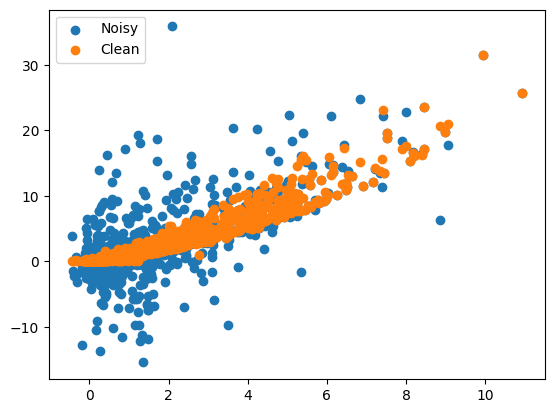

In [6]:
pred = model(val_dataset.data.to("cuda"))
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.clean_labels[:,0], label="Clean")
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
plt.legend()
plt.show()

PearsonRResult(statistic=0.9650387710260152, pvalue=0.0) 27.335363


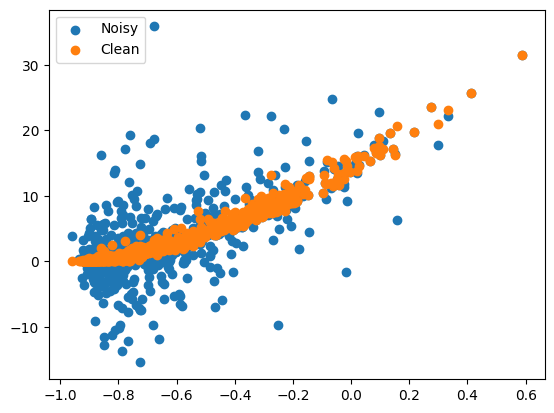

In [8]:
pred = model(val_dataset.data.to("cuda"))
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.clean_labels[:,0], label="Clean")
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
plt.legend()
plt.show()

PearsonRResult(statistic=0.9771473876505918, pvalue=0.0) 2.4976099


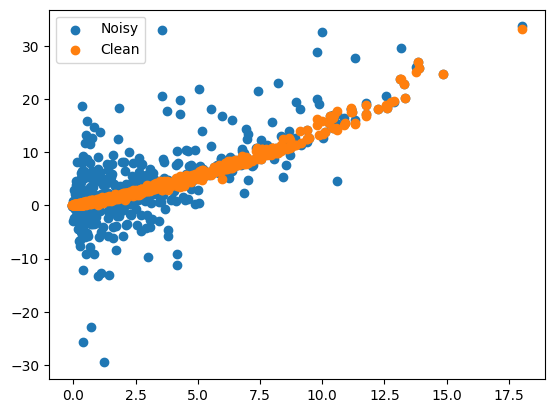

In [75]:
pred = model(dataset.data.to("cuda"))
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.clean_labels[:,0], label="Clean")
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- dataset.clean_labels[:,0].cpu().detach().numpy())**2))
plt.legend()
plt.show()

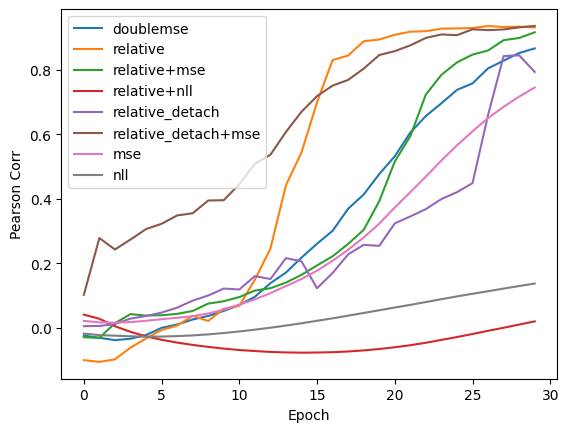

In [80]:
model_names = ["doublemse","relative","relative+mse","relative+nll","relative_detach","relative_detach+mse", "mse", "nll"]
#model_names = ["doublemse", "mse", "nll"]
for model_name in model_names:
    plt.plot(val_losses[f"{model_name}_pearson"][:30], label=model_name)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pearson Corr")
plt.show()

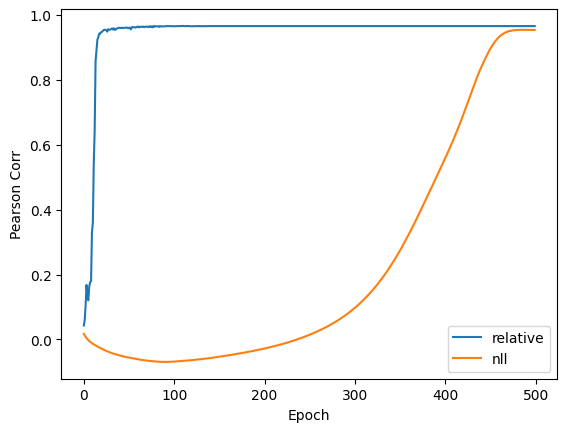

In [11]:
model_names = ["relative", "nll"]
#model_names = ["doublemse", "mse", "nll"]
for model_name in model_names:
    plt.plot(val_losses[f"{model_name}_pearson"], label=model_name)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pearson Corr")
plt.show()

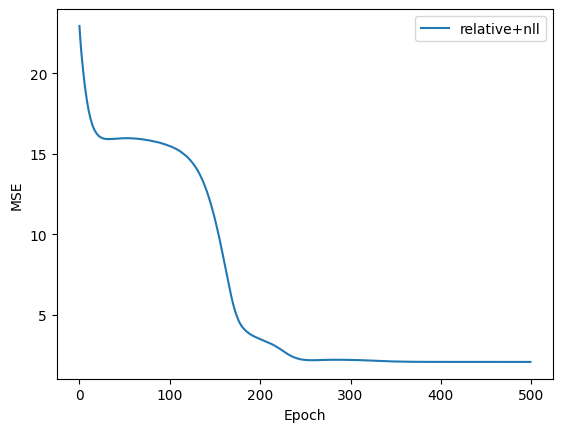

In [74]:
for model_name in model_names:
    plt.plot(val_losses[f"{model_name}_mse"], label=model_name)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

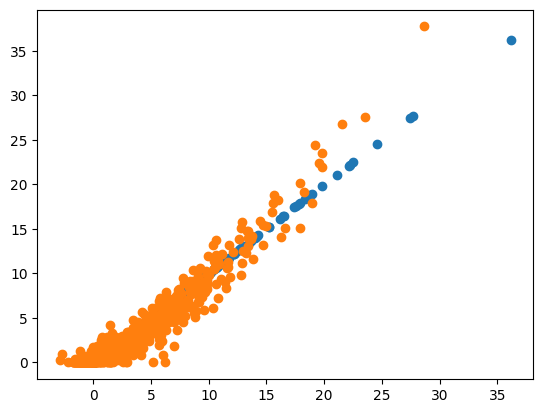

In [34]:
plt.scatter(val_dataset.clean_labels[:,0],val_dataset.clean_labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.clean_labels[:,0], label="Clean")

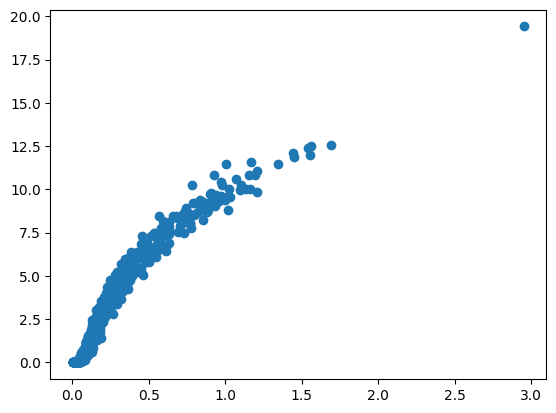

In [40]:
plt.scatter(torch.nn.functional.softplus(pred[:,1]).cpu().detach().numpy(),torch.nn.functional.softplus(val_dataset.data[:,-1]*5), label="Uncertainty")

In [10]:
stats.pearsonr(predboth.cpu().detach().numpy()[:,0], dataset.labels[:,0])

PearsonRResult(statistic=0.9499538246314237, pvalue=0.0)

PearsonRResult(statistic=0.9989940112735061, pvalue=0.0)

In [27]:
stats.pearsonr(predrel2.cpu().detach().numpy()[:,0], dataset.labels[:,0])

PearsonRResult(statistic=0.9526229577305851, pvalue=0.0)

In [35]:
torch.nn.functional.softplus(pred[:,1])

tensor([0.6824, 0.6368, 0.4941, 0.6291, 0.5862, 0.5145, 0.9878, 0.8812, 0.5315,
        0.7388, 0.5402, 0.6838, 0.5781, 0.4935, 0.6143, 0.5793, 0.6271, 0.4684,
        0.3881, 0.5727, 0.4373, 0.5226, 0.6866, 0.3979, 0.4398, 0.6560, 0.7880,
        0.8959, 0.6628, 0.8057, 0.3621, 0.6329, 0.6162, 0.7042, 0.9952, 0.5337,
        0.2970, 0.7158, 0.5409, 0.5313, 0.4661, 0.5808, 0.4718, 0.8788, 0.8308,
        0.5070, 0.9269, 0.6700, 0.6574, 0.5369, 0.5245, 0.4844, 0.5610, 0.4917,
        0.5195, 0.4377, 0.6515, 0.4419, 0.5501, 0.6088, 0.7799, 0.3982, 0.5625,
        1.1271, 0.5697, 0.6594, 0.4790, 0.6934, 0.5366, 0.7078, 0.5222, 0.5778,
        0.5557, 0.4940, 0.4404, 0.4606, 0.4862, 0.7667, 0.9855, 0.6799, 0.7249,
        0.6042, 0.5601, 0.5541, 0.9975, 0.6483, 0.4180, 0.5807, 0.5911, 0.5530,
        0.6708, 0.5564, 0.5056, 0.3485, 0.4972, 0.6518, 0.6214, 0.9343, 0.5211,
        0.5820, 0.6893, 0.5409, 0.5724, 0.4308, 0.4444, 0.7479, 0.6267, 0.3550,
        0.6067, 0.4696, 0.5777, 0.5240, 

In [123]:
pred

tensor([[ 2.8232e+00, -7.4798e-04],
        [ 2.8132e+00,  2.1387e+00],
        [ 2.8421e+00, -3.9194e-01],
        ...,
        [ 2.8211e+00, -4.6751e-01],
        [ 2.8244e+00, -2.8327e+00],
        [ 2.8305e+00,  2.7832e-01]], device='cuda:0', grad_fn=<StackBackward0>)

In [284]:
model.in_layer.weight, model.in_layer.bias

(Parameter containing:
 tensor([[ 0.2608,  0.2177,  0.0611,  0.1495, -0.2614, -0.0702],
         [-0.0446,  0.3684,  0.3918, -0.3911, -0.0778, -0.3137],
         [-0.2281, -0.1544, -0.1947,  0.3327, -0.3574, -0.2402],
         [-0.0150, -0.2123, -0.2837, -0.2381, -0.1455, -0.2466],
         [ 0.4005,  0.4969, -0.0776,  0.2427,  0.1284,  0.2170],
         [ 0.3545,  0.3840,  0.4104,  0.2306,  0.3560,  0.2177],
         [-0.2332, -0.1948, -0.1682, -0.1058, -0.1522,  0.2921],
         [-1.1671, -0.0184, -0.6388,  0.8295,  1.0356,  0.4328],
         [ 0.2981,  0.2929, -0.0428, -0.1008,  0.3125,  0.2459],
         [ 0.0252, -0.3151, -0.2877, -0.2223,  0.1280, -0.0137],
         [ 0.2597,  0.3947, -0.0641,  0.9939, -0.3111, -0.1918],
         [-0.0449, -0.2825, -0.2194,  0.1707, -0.3344, -0.3211],
         [ 0.0899,  0.6040,  0.6558,  0.2540,  0.5732, -0.1690],
         [-0.1447, -0.1661, -0.5113, -0.4167,  0.0947, -0.1819],
         [-0.3308,  0.0654,  0.1283, -0.5225, -0.2588, -0.2064],
  

In [184]:
torch.Tensor([[-1,-0.1,0.1,0.4,1.3]])

tensor([[-1.0000, -0.1000,  0.1000,  0.4000,  1.3000]])